 # Scikit-Learn ve  Keras ile Ensemble Modelleme
 
 ## Öznitelik Önemini Değerlendirme (Evaluating Feature Importance)
 
Feature Importance, bize her bir özelliğin bir sinir ağının veya başka bir modelin tahmini için ne kadar önemli olduğu hakkında bilgi verir. Sinir ağları için özelliğin önemini değerlendirmenin birçok farklı yolu vardır. Sinir ağları için aşağıdaki yöntemler mevcuttur.</br>

<li>Connection Weights Algorithm</li>
<li>Partial Derivatives</li>
<li>Input Perturbation</li>
<li>Sensitivity Analysis</li>
<li>Forward Stepwise Addition</li>
<li>Improved Stepwise Selection 1</li>
<li>Backward Stepwise Elimination</li>
<li>Improved Stepwise Selection</li>

Burada, Input Perturbation özellik sıralama algoritması anlatılacaktır. Bu algoritma, herhangi bir regresyon veya sınıflandırma ağıyla çalışmaktadır.Bu algoritma  Leo Breiman tarafından  rastgele ormanlar hakkındaki makalesinde sunulmuştur. Bu algoritmayı rastgele ormanlarla birlikte sunmasına rağmen, modelden bağımsızdır ve herhangi bir denetimli öğrenme modeli için uygundur. Input Perturbation algoritması olarak bilinen bu algoritma, bir veri kümesinden ayrı ayrı karıştırılan girdilerin her biri ile eğitimli bir modelin doğruluğunu değerlendirerek çalışır. </br>

Bu algoritma, bir sınıflandırma problemini değerlendirmek için log loss ve regresyon için RMSE'yi kullanmaktadır.

In [4]:
import pandas as pd
from sklearn.metrics import mean_squared_error, log_loss
import scipy as sp
import numpy as np

def pertubration_rank(model, X, y, names, regression):
    errors = []
    
    for i in range(X.shape[1]):
        hold = np.array(X[:, i])
        np.random.shuffle(X[:, i])
        
        if regression:
            pred = model.predict(X)
            errors.append(mean_squared_error(y, pred))
        else:
            pred = model.predict_proba(X)
            errors.append(log_loss(y, pred))
        
        X[:, i] = hold
    
    max_error = np.max(errors)
    importance = [e / max_error for e in errors]

    data = {'name': names, 'error': errors, 'importance': importance}
    result = pd.DataFrame(data, columns=['name', 'error', 'importance'])
    result.sort_values(by=['importance'], ascending=False, inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

# Classification and Input Perturbation Ranking

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split


df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/iris.csv', 
                na_values=['NA', '?'])

X = df[['sepal_l', 'sepal_w', 'petal_l', 'petal_w']].values
dummies = pd.get_dummies(df['species'])
species = dummies.columns
y = dummies.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(50, input_dim=X.shape[1], activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, verbose=2, epochs=100)

Epoch 1/100
4/4 - 0s - loss: 2.0061
Epoch 2/100
4/4 - 0s - loss: 1.5384
Epoch 3/100
4/4 - 0s - loss: 1.3198
Epoch 4/100
4/4 - 0s - loss: 1.1909
Epoch 5/100
4/4 - 0s - loss: 1.0542
Epoch 6/100
4/4 - 0s - loss: 0.9674
Epoch 7/100
4/4 - 0s - loss: 0.9075
Epoch 8/100
4/4 - 0s - loss: 0.8683
Epoch 9/100
4/4 - 0s - loss: 0.8331
Epoch 10/100
4/4 - 0s - loss: 0.8019
Epoch 11/100
4/4 - 0s - loss: 0.7713
Epoch 12/100
4/4 - 0s - loss: 0.7364
Epoch 13/100
4/4 - 0s - loss: 0.7083
Epoch 14/100
4/4 - 0s - loss: 0.6840
Epoch 15/100
4/4 - 0s - loss: 0.6642
Epoch 16/100
4/4 - 0s - loss: 0.6453
Epoch 17/100
4/4 - 0s - loss: 0.6276
Epoch 18/100
4/4 - 0s - loss: 0.6113
Epoch 19/100
4/4 - 0s - loss: 0.5965
Epoch 20/100
4/4 - 0s - loss: 0.5818
Epoch 21/100
4/4 - 0s - loss: 0.5684
Epoch 22/100
4/4 - 0s - loss: 0.5558
Epoch 23/100
4/4 - 0s - loss: 0.5437
Epoch 24/100
4/4 - 0s - loss: 0.5323
Epoch 25/100
4/4 - 0s - loss: 0.5216
Epoch 26/100
4/4 - 0s - loss: 0.5112
Epoch 27/100
4/4 - 0s - loss: 0.5026
Epoch 28/1

In [2]:
from sklearn.metrics import accuracy_score

pred = model.predict(X_test)
predict_classes = np.argmax(pred, axis=1)
expected_classes = np.argmax(y_test, axis=1)
acc_score = accuracy_score(expected_classes, predict_classes)
acc_score


0.9666666666666667

In [5]:
names = list(df.columns)
names.remove('species')
rank = pertubration_rank(model, X_test, y_test, names, False)
rank

Instructions for updating:
Please use `model.predict()` instead.


,name,error,importance
0,petal_l,2.076535,1.000000
1,petal_w,0.764929,0.368368
2,sepal_l,0.187102,0.090103
3,sepal_w,0.164346,0.079144


# Regression and Input Perturbation Ranking

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/auto-mpg.csv',                 
                na_values=['NA', '?'])


df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

X = df[['cylinders','displacement','horsepower','weight',
        'acceleration','year','origin']].values
y = df['mpg'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(25, input_dim=X.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, verbose=2, epochs=100)

Epoch 1/100
10/10 - 0s - loss: 158333.4375
Epoch 2/100
10/10 - 0s - loss: 36110.2852
Epoch 3/100
10/10 - 0s - loss: 2571.4780
Epoch 4/100
10/10 - 0s - loss: 2961.1277
Epoch 5/100
10/10 - 0s - loss: 2609.2681
Epoch 6/100
10/10 - 0s - loss: 1147.0244
Epoch 7/100
10/10 - 0s - loss: 976.5759
Epoch 8/100
10/10 - 0s - loss: 1012.1773
Epoch 9/100
10/10 - 0s - loss: 939.4510
Epoch 10/100
10/10 - 0s - loss: 922.3546
Epoch 11/100
10/10 - 0s - loss: 914.5435
Epoch 12/100
10/10 - 0s - loss: 903.9374
Epoch 13/100
10/10 - 0s - loss: 894.3073
Epoch 14/100
10/10 - 0s - loss: 885.1788
Epoch 15/100
10/10 - 0s - loss: 878.3129
Epoch 16/100
10/10 - 0s - loss: 869.5519
Epoch 17/100
10/10 - 0s - loss: 857.3226
Epoch 18/100
10/10 - 0s - loss: 848.4277
Epoch 19/100
10/10 - 0s - loss: 837.5118
Epoch 20/100
10/10 - 0s - loss: 827.2177
Epoch 21/100
10/10 - 0s - loss: 819.4198
Epoch 22/100
10/10 - 0s - loss: 808.4346
Epoch 23/100
10/10 - 0s - loss: 798.1693
Epoch 24/100
10/10 - 0s - loss: 786.8827
Epoch 25/100
10

In [8]:
from skater.core.explanations import Interpretation
interpreter = Interpretation()
interpreter.load_data(X_test, feature_names=['cylinders','displacement','horsepower','weight',
        'acceleration','year','origin'])


[1/7] features ██------------------ Time elapsed: 0 secondsWARNING:tensorflow:Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
[2/7] features █████--------------- Time elapsed: 0 secondsWARNING:tensorflow:Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
[3/7] features ████████------------ Time elapsed: 0 secondsWARNING:tensorflow:Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
[4/7] features ███████████--------- Time elapsed: 0 secondsWARNING:tensorflow:Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
[5/7] features ██████████████------ Time elapsed: 0 secondsWARNING:tensorflow:Network returning invalid prob

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

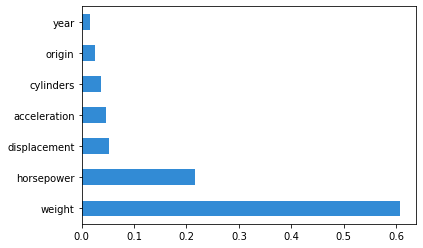

In [9]:
from skater.model import InMemoryModel
pyint_model = InMemoryModel(model.predict_proba, examples=X_test)
interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=True)


In [7]:
names = list(df.columns)
names.remove('name')
names.remove('mpg')
rank = pertubration_rank(model, X_test, y_test, names, True)
rank

,name,error,importance
0,acceleration,169.880932,1.000000
1,origin,167.724839,0.987308
2,year,164.187733,0.966487
3,cylinders,160.176224,0.942873
4,displacement,159.581775,0.939374
5,horsepower,140.314277,0.825957
6,weight,113.418618,0.667636


# Kaggle Dataset Örneği

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


df_train = pd.read_csv('train.csv', na_values=['NA', '?'])
df_test = pd.read_csv('test.csv', na_values=['NA', '?'])

df_train.shape

(3751, 1777)

In [25]:
X_columns = df_train.columns.drop('Activity')
X = df_train[X_columns].values
y = df_train['Activity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(25, input_dim=X.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          callbacks=[monitor],verbose=0, epochs=1000)model.compile(loss='binary_crossentropy', optimizer='adam')


Epoch 00009: early stopping


In [27]:
pred = model.predict(X_test).flatten()
pred = np.clip(pred, a_min=1e-6, a_max=(1-1e-6))
print('log loss = ', log_loss(y_test, pred))


log loss =  0.5641294002190853


In [29]:
pred = pred > 0.5
score = accuracy_score(y_test, pred)
score

0.7549933422103862

In [32]:
X_submit = df_test[X_columns].values
pred_submit = model.predict(X_submit).flatten()
pred_submit

array([0.99343234, 0.97884357, 0.38377544, ..., 0.9187938 , 0.8782425 ,
       0.36218733], dtype=float32)

In [33]:
names = list(df_train.columns)
names.remove('Activity')
rank = pertubration_rank(model, X_test, y_test, names, False)
rank

,name,error,importance
0,D27,0.628330,1.000000
1,D1402,0.572884,0.911757
2,D51,0.571632,0.909764
3,D1188,0.571098,0.908914
4,D1049,0.571067,0.908864
...,...,...,...
1771,D1286,0.560469,0.891997
1772,D1337,0.560216,0.891595
1773,D1390,0.559554,0.890541
1774,D956,0.558911,0.889518
